In [1]:
import torch
import os
import glob
import pickle

if 'DISPLAY' in os.environ:
    del os.environ['DISPLAY']
    
user_env = os.environ['USER']
job_env = os.environ['SLURM_JOB_ID']
import sys
sys.path.append('../externals/hnn-core')
sys.path.append('../../externals/hnn-core')
sys.path.append('../code')
from tqdm import tqdm
from torch import optim
import numpy as np
import datetime
from pathlib import Path
from utils import (load_prerun_simulations, filter_borders, filter_nzeros, filter_peakproeminence,
                   filter_removeoutliers, filter_peaktime, linear_scale_forward, simulator_hnn,
                   UniformPrior, PriorBetaFiltered, build_flow, hnn_beta_param_function,
                   linear_scale_array)
from functools import partial
import joblib
from distributed import Client
from dask_jobqueue import SLURMCluster
import dask
from joblib import Parallel, delayed
import datetime
import dask.bag as db
from sbi import inference as sbi_inference
from hnn_core import calcium_model, jones_2009_model
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import dill
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style("white")

/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


In [2]:
data_path = '../data'
dpl_orig, theta_orig = np.load(f'{data_path}/sbi_sims/dpl_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)

In [3]:
filters = [filter_borders, filter_nzeros, filter_peakproeminence, filter_peaktime, filter_removeoutliers]
# Filter simulations
dpl_filter, theta_filter = dpl_orig, theta_orig
for filter_func in filters:
    dpl_filter, theta_filter = filter_func(dpl_filter, theta_filter)

In [4]:
labelsize = 18
titlesize = 18
ticksize = 15
alpha=0.5
ylim = [-0.055, 0.029]
xlim = [0, 500]
xtimes = np.linspace(0, 500, dpl_filter.shape[1])

plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
orig_plot_data = dpl_orig[:50,:]
_ = plt.plot(xtimes, orig_plot_data.T, color='k', alpha=alpha)
plt.plot(xtimes, np.mean(orig_plot_data, axis=0), color='r')
plt.xticks([])
_ = plt.yticks(size=ticksize)
plt.ylabel('Dipole (nAm)', size=labelsize)
plt.ylim(ylim)
plt.xlim(xlim)
plt.title('Before Filtering', size=titlesize)


plt.subplot(2,1,2)
filtered_plot_data = dpl_filter[:50,:]
_ = plt.plot(xtimes, filtered_plot_data.T, color='k', alpha=alpha)
plt.plot(xtimes, np.mean(filtered_plot_data, axis=0), color='r')
_ = plt.xticks(size=ticksize)
_ = plt.yticks(size=ticksize)
plt.xlabel('Time (ms)', size=labelsize)
plt.ylabel('Dipole (nAm)', size=labelsize)
plt.ylim(ylim)
plt.xlim(xlim)
plt.title('After Filtering', size=titlesize)

plt.tight_layout()
plt.savefig('../figures/beta_filter.svg')

In [7]:
prior_filtered = PriorBetaFiltered(parameters=list(prior_dict.keys()))
optimizer = optim.Adam(prior_filtered.flow.parameters())

num_iter = 1000
for i in tqdm(range(num_iter)):
    optimizer.zero_grad()
    loss = -prior_filtered.flow.log_prob(inputs=theta_filter).mean()
    loss.backward()
    optimizer.step()
state_dict = prior_filtered.flow.state_dict()

 34%|███▍      | 340/1000 [05:59<11:37,  1.06s/it]


KeyboardInterrupt: 

In [8]:
num_sims = 1000
theta_samples = prior_filtered.sample((num_sims,))

In [9]:
all_labels = list(prior_dict.keys())
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
samples_transformed = linear_scale_array(theta_samples.numpy(), all_bounds)
df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}

df_temp = pd.DataFrame(df_dict)
df = df_temp.iloc[:, 4:]

In [13]:
tick_dict = dict()
nval_samples = 10
for p_idx, param_dict in enumerate(prior_dict.values()):
    bounds = param_dict['bounds']
    ticks = np.round(np.linspace(bounds[0], bounds[1], nval_samples), decimals=2)
    tick_dict[f'p{p_idx}_tick_pos'] = ticks
    
    ticks = ticks.astype(str)
    ticks[1:-1] = np.repeat('', nval_samples-2)
    tick_dict[f'p{p_idx}_tick_labels'] = ticks

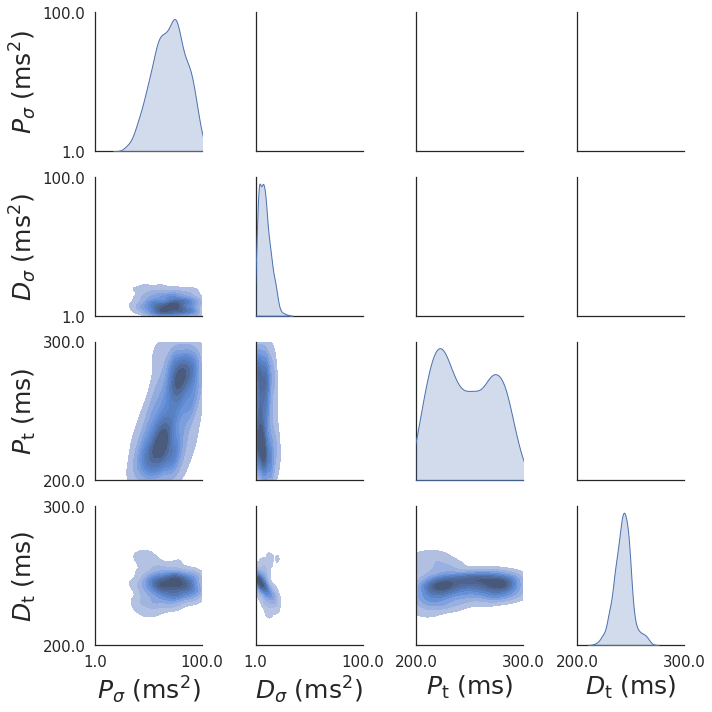

In [48]:
%matplotlib inline
labelsize=25
ticksize=15

param_labels = ['$P_\sigma$ ($\mathrm{ms}^2$)', '$D_\sigma$ ($\mathrm{ms}^2$)', '$P_\mathrm{t}$ (ms)', '$D_\mathrm{t}$ (ms)']

all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()][4:]
g = sns.PairGrid(df, diag_sharey=False, corner=False)
g.map_lower(sns.kdeplot, fill=True, color='C0')
g.map_diag(sns.kdeplot, fill=True, color='C0')

for idx in range(4):    
    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])

    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[3,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

            
    g.axes[idx, 0].set_yticks(tick_dict[f'p{idx+4}_tick_pos'])
    g.axes[3, idx].set_xticks(tick_dict[f'p{idx+4}_tick_pos'])
    g.axes[idx, 0].set_yticklabels(tick_dict[f'p{idx+4}_tick_labels'], fontsize=ticksize, rotation=0)
    g.axes[3, idx].set_xticklabels(tick_dict[f'p{idx+4}_tick_labels'], fontsize=ticksize, rotation=0)
    
plt.tight_layout()
plt.savefig('../figures/filtered_distribution.svg')